In [3]:

import pandas as pd
import tqdm
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.cm as cm
import numpy as np
import seaborn as sns
from wordcloud import WordCloud, ImageColorGenerator


filein  = 'global_cities_dataset_2020420.csv'

# because the file is large, we first read the header and get the length of the rows
linec=0
with open(filein, encoding='utf8') as f:
    for line in f:
        if (linec==0):
            print(line)
        linec+=1

print('number of rows in csvfile:', linec)

,country_id,country_name,area_id,area_name,indicator_id,indicator_name,value,value_unit,value_multiplier,value_type,year

number of rows in csvfile: 11045986


In [9]:
# create a function to read data in chunks and aggregate years into mean, min, max, std
def readfile(filein, linec):
    # define a chunksize
    chunksize = 500000

    # initiate a blank dataframe
    data = pd.DataFrame()

    grupcolumns = ['country_id', 'country_name', 'area_id', 'area_name','indicator_id', 'indicator_name','value_unit','value_multiplier','value_type']

    # tqdm context
    with tqdm.tqdm (total=linec, desc="chunks read: ") as bar:
        # enumerate chunks read without low_memory
        for i, chunk in enumerate(pd.read_csv(filein, chunksize=chunksize, low_memory=False)):


            chunk.update(chunk.loc[chunk['value_multiplier'].str.contains("Millions", na=False),['value']].apply(lambda x: (x * 1000000)))
            chunk.update(chunk.loc[chunk['value_multiplier'].str.contains("Thousands", na=False),['value']].apply(lambda x: (x * 1000)))

        # aggregate over values to extract statistical insights. mean, min, max, standard deviation and count
            procchunk = chunk.groupby(grupcolumns).agg(
                                    val=pd.NamedAgg(column='value', aggfunc="mean"),
                                    # vmin=pd.NamedAgg(column='value', aggfunc="min"),
                                    # vmax=pd.NamedAgg(column='value', aggfunc="max"),
                                    vstd=pd.NamedAgg(column='value', aggfunc="std"),
                                    countV=pd.NamedAgg(column="value", aggfunc="count")).reset_index()
        # get only value_type L
            procchunk = procchunk.loc[procchunk['value_type']=='L']
        # dump processed chunks to the data file
            data = data.append(other=procchunk)

            bar.update(chunksize)

    print("end of reading chunks...")
    # aggregate the dump file to make sure we grouped everything right, we take the mean of std and sum of counts this time
    
    data = data.groupby(grupcolumns).agg(
                                    val=pd.NamedAgg(column='val', aggfunc="mean"),
                                    # vmin=pd.NamedAgg(column='vmin', aggfunc="min"),
                                    # vmax=pd.NamedAgg(column='vmax', aggfunc="max"),
                                    vstd=pd.NamedAgg(column='vstd', aggfunc="mean"), 
                                    countV=pd.NamedAgg(column="countV", aggfunc="sum")).reset_index()
    
    return(data)

In [10]:
data = readfile(filein, linec)
# remove indicators that use local currency LC
data = data.loc[~(data['indicator_id'].str.contains("LC"))]
data = data.loc[~(data['value_multiplier'].str.contains("2012=100"))]

data.drop(columns='value_multiplier', inplace=True)

# save processed data to csv
data.to_csv('processed.csv', index=False)



chunks read: : 11500000it [00:53, 216760.13it/s]
end of reading chunks...


In [4]:
data = pd.read_csv('processed.csv')

In [6]:
# create a list of unique indicators
data[['indicator_id','indicator_name']]

sorted = data.sort_values(['indicator_id', 'indicator_name'], ascending = [True, False])

first = sorted.groupby('indicator_id').first().reset_index()
first[['area_id','indicator_id', 'indicator_name']].to_csv('all_indexes.csv')

In [98]:
# investigate certain indicators to whom they belong to
print('1. ', data[data['indicator_id']=='POPTOTT']['country_name'].unique())
print('2. ', data[data['indicator_id']=='HHTOT']['country_name'].unique())
print('3. ', data[(data['indicator_id'].str.endswith('EC')) | (data['indicator_id']
                .str.endswith('EN'))]['country_name'].unique())
print('4. ', data[(data['indicator_id'].str.endswith('CNCA')) | (data['indicator_id']
                .str.endswith('CNNA'))]['country_name'].unique())
print('5. ', data[data['indicator_id'].str.contains('XEMP')]['country_name'].unique())

1.  ['Austria' 'Belgium' 'Bulgaria' 'Switzerland' 'Cyprus' 'Czechia' 'Germany'
 'Denmark' 'Spain' 'Estonia' 'EU excluding UK' 'Eurozone' 'Finland'
 'France' 'United Kingdom of Great Britain and Northern Ireland' 'Greece'
 'Croatia' 'Hungary' 'Ireland' 'Italy' 'Lithuania' 'Luxembourg' 'Latvia'
 'Malta' 'Netherlands' 'Norway' 'Poland' 'Portugal' 'Romania'
 'Russian Federation' 'Slovakia' 'Slovenia' 'Sweden' 'Turkey']
2.  ['Canada' 'United States of America']
3.  ['Austria' 'Belgium' 'Bulgaria' 'Switzerland' 'Cyprus' 'Czechia' 'Germany'
 'Denmark' 'Spain' 'Estonia' 'EU excluding UK' 'Eurozone' 'Finland'
 'France' 'United Kingdom of Great Britain and Northern Ireland' 'Greece'
 'Croatia' 'Hungary' 'Ireland' 'Italy' 'Lithuania' 'Luxembourg' 'Latvia'
 'Malta' 'Netherlands' 'Norway' 'Poland' 'Portugal' 'Romania'
 'Russian Federation' 'Slovakia' 'Slovenia' 'Sweden' 'Turkey']
4.  ['Canada']
5.  ['United States of America']


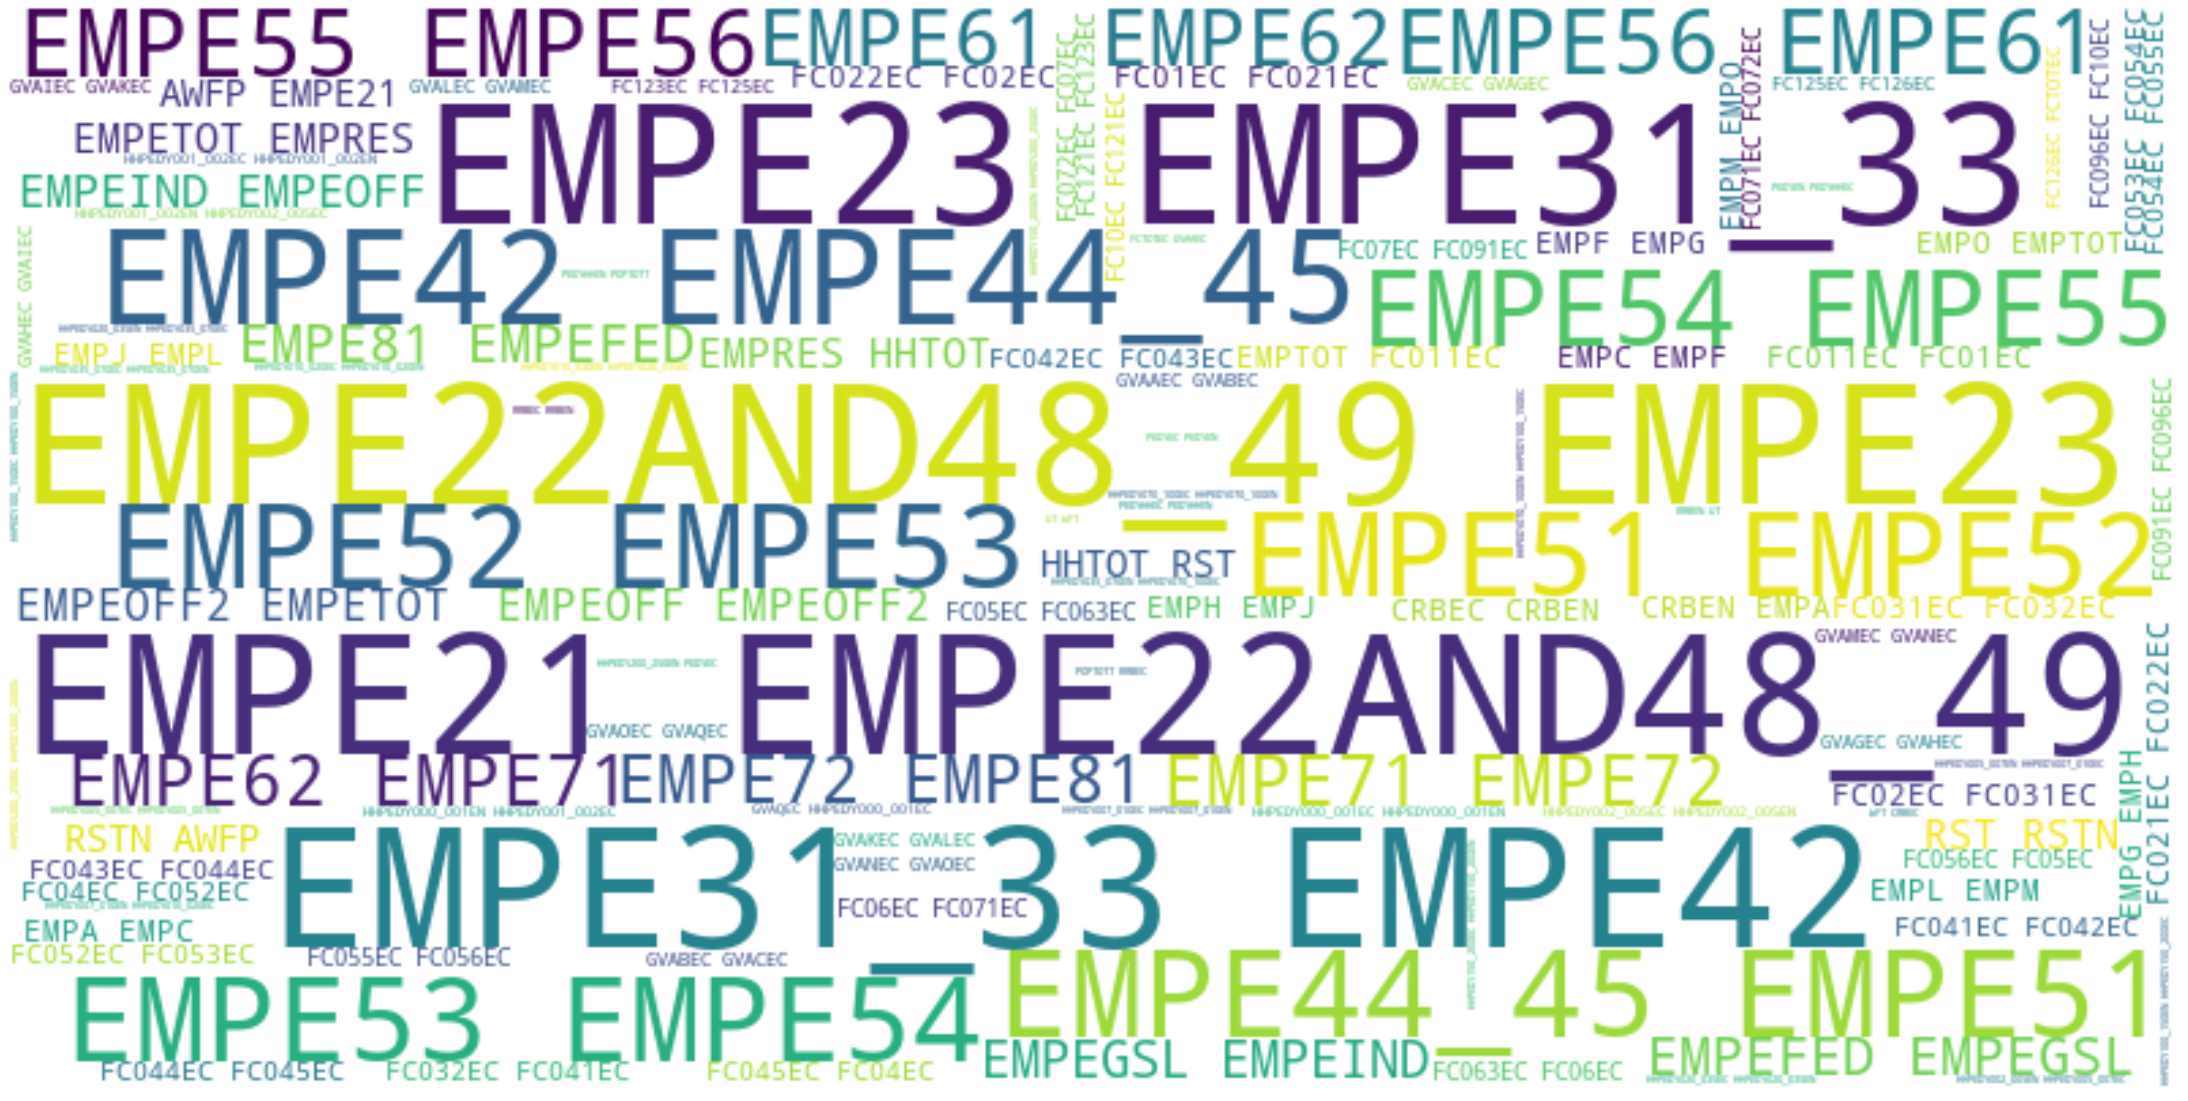

In [12]:
# Create and generate a word cloud image:
wordcloud = WordCloud(background_color="white", width=800, height=400).generate(' '.join(data['indicator_id']))

# Display the generated image:
plt.figure( figsize=(40,20))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [14]:
# select only the countries 
list_countries = data['country_id'].unique()
print('Total countries: ', len(list_countries))

# select only the countries 
list_areas = data[~data['area_id'].isin(list_countries)]['area_id'].unique()
print('Total countries: ', len(list_areas))

Total countries:  166
Total countries:  6482


Indiciators:  489 Countries:  166


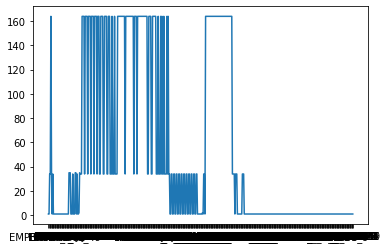

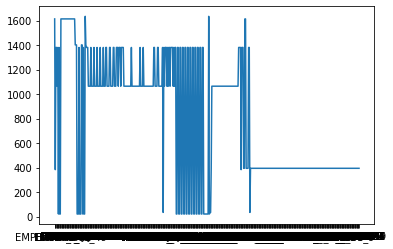

In [30]:
# Select only the countries
countryCom = data[data['area_id'].isin(list_countries)].reset_index(drop=True)

# get the number of idicators and the countries
nIndicators = countryCom['indicator_id'].nunique()
nCountries = countryCom['country_id'].nunique()
print('Indiciators: ', nIndicators, 'Countries: ', nCountries)
# find how how many indicators are common per country
plt.plot(data.groupby("indicator_id")["country_id"].nunique())
plt.show()

# find how how many indicators are common per area
plt.plot(data.groupby("indicator_id")["area_id"].nunique())
plt.show()


In [71]:
# we see that some countries have different country and area id. we replace area_id with country_id

not_list = list(set(list_countries).difference(countryCom['country_id'].unique()))

for i in not_list:
    data.update(data.loc[data['country_id']==i,['area_id']].replace(r'[^\d]+', i, regex=True))

data['a_id'] = data['country_name']+'_'+data['area_name']
countryCom = data[data['area_id'].isin(list_countries)].reset_index(drop=True)

# get the number of idicators and the countries
nIndicators=countryCom['indicator_id'].nunique()
nCountries=countryCom['country_id'].nunique()
print('Indiciators: ', nIndicators, 'Countries: ', nCountries)



Indiciators:  489 Countries:  166


<AxesSubplot:ylabel='Frequency'>

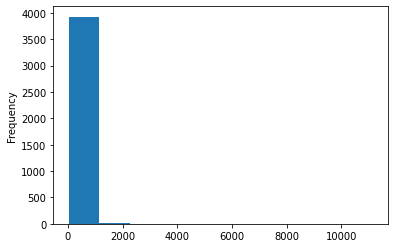

In [267]:
#find how many indicators per area
indic_per_area = data.groupby('area_id')['indicator_id'].size()
indic_per_area.plot(kind='hist')



In [72]:
# select indicators that are comon ammong all the countries
def commonIndicators(selection):
    maxcommon = selection.groupby("indicator_id")["area_id"].nunique().max()
    #get list of common indicators
    indicators = (selection.groupby("indicator_id")["area_id"].nunique()==maxcommon)
    indicators = list(indicators.where(indicators == True).dropna().index)

    # keep only the common indicators
    selection = selection.loc[selection['indicator_id'].isin(indicators)]
    
    #save indicators
    selection[['indicator_id','indicator_name']].to_csv('indicators.csv')

    #reshape table
    # val_cols=['val',	'vmin',	'vmax',	'vstd']
    val_cols=[ 'val',	'vstd']
    newSelection = selection.pivot(index=['a_id'], columns='indicator_id', values=val_cols).reset_index()
    newSelection.columns = newSelection.columns.to_series().str.join('_')
    return(newSelection)

countries = commonIndicators(countryCom)
countries.to_csv('countries.csv', index=False)

In [73]:
euro_areas = list(data[data['indicator_id']=='POPTOTT']['country_name'].unique())
euro_areas = data[(data['country_name'].isin(euro_areas)) & (data['area_id']!=data['country_id'])]
euro_areas = commonIndicators(euro_areas)
euro_areas.to_csv('euro_areas.csv', index=False)

In [99]:
US_areas = list(data[data['indicator_id'].str.contains('XEMP')]['country_name'].unique())
US_areas = data[(data['country_name'].isin(US_areas)) & (data['area_id']!=data['country_id'])]
US_areas = commonIndicators(US_areas)
US_areas.to_csv('US_areas.csv', index=False)

ValueError: Index contains duplicate entries, cannot reshape